In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import random
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from dataset import PlayingCardDataset
from tqdm import tqdm
import json
from constants.paths_const import DATA_PATH, ANNOTATIONS_ORG_FILE

In [2]:
train_imgs_path = os.path.join(DATA_PATH, "train")
train_annotations_path = os.path.join(DATA_PATH, "train", ANNOTATIONS_ORG_FILE)

In [3]:
# Read annotations file
with open(train_annotations_path, 'r') as f:
    annotations_data = json.load(f)

# Get category from annotations file
category_mapping = {cat['id']: cat['name'] for cat in annotations_data['categories']}
print(category_mapping)

{0: 'cards', 1: '10C', 2: '10D', 3: '10H', 4: '10S', 5: '2C', 6: '2D', 7: '2H', 8: '2S', 9: '3C', 10: '3D', 11: '3H', 12: '3S', 13: '4C', 14: '4D', 15: '4H', 16: '4S', 17: '5C', 18: '5D', 19: '5H', 20: '5S', 21: '6C', 22: '6D', 23: '6H', 24: '6S', 25: '7C', 26: '7D', 27: '7H', 28: '7S', 29: '8C', 30: '8D', 31: '8H', 32: '8S', 33: '9C', 34: '9D', 35: '9H', 36: '9S', 37: 'AC', 38: 'AD', 39: 'AH', 40: 'AS', 41: 'JC', 42: 'JD', 43: 'JH', 44: 'JS', 45: 'KC', 46: 'KD', 47: 'KH', 48: 'KS', 49: 'QC', 50: 'QD', 51: 'QH', 52: 'QS'}


In [4]:
image_ids = []
file_names = []
category_names = []
bounding_boxes = []

for img in annotations_data['images']:
    # Get information from image key in annotations file
    image_ids.append(img['id'])
    file_names.append(img['file_name'])

    # Get information from annotations key in annotations file
    annotations = [ann for ann in annotations_data['annotations'] if ann['image_id'] == img['id']]
    category_names.append([category_mapping[ann['category_id']] for ann in annotations])
    bounding_boxes.append([ann['bbox'] for ann in annotations])

# Create DataFrame
data = {
    'ImageID': image_ids,
    'FileName': file_names,
    'Categories': category_names,
    'BoundingBoxes': bounding_boxes,
}

df = pd.DataFrame(data)
df.head()

,ImageID,FileName,Categories,BoundingBoxes
0,0,734511299_jpg.rf.3ef95488968e9a630472fc6e58dc9...,"[9D, 10D, AH, AH]","[[227, 13, 50, 64.291], [174, 62, 60, 59.349],..."
1,1,399475375_jpg.rf.3efabd24b3dd3f61218a8c8d4168c...,"[2H, QS, 10S, 10S]","[[392, 342, 46.134, 23.268], [389, 377, 44.134..."
2,2,165129301_jpg.rf.3f18a949f904a5b4ac7a9ec802856...,"[10H, 3D, 9D, 9D]","[[131, 387, 68.285, 49.396], [184, 435, 63.343..."
3,3,796425883_jpg.rf.3f095992704c3c072dab1b386c9bf...,"[5C, 6H, 8H, 8H]","[[269, 181, 36, 44.209], [300, 167, 30, 43.175..."
4,4,203940115_jpg.rf.3ee8c3c05c1e37d6ae172d84d6ff8...,"[10D, 6S, QD, QD]","[[377, 311, 28, 49.163], [417, 312, 29, 49.169..."


In [5]:
df.describe()

,ImageID
count,21203.000000
mean,10601.000000
std,6120.923215
min,0.000000
25%,5300.500000
50%,10601.000000
75%,15901.500000
max,21202.000000


In [6]:
# Create annos.csv file from json file
annos_csv_path = os.path.join(DATA_PATH, "annos.csv")
df.to_csv(annos_csv_path, index=False)

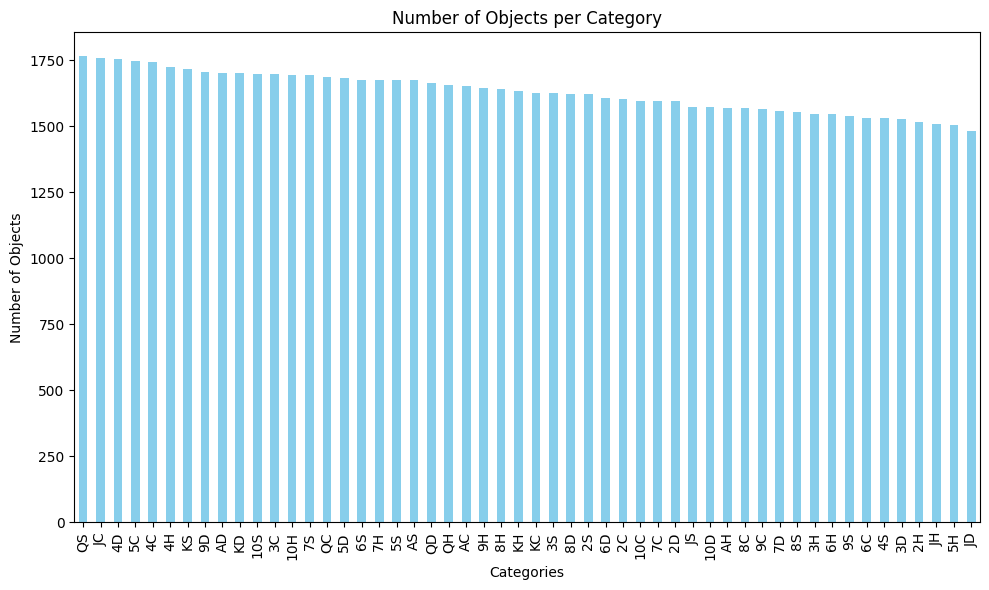

In [7]:
# Count the number of each category
category_count = df['Categories'].explode().value_counts()

# Show bar chart
plt.figure(figsize=(10, 6))
category_count.plot(kind='bar', color='skyblue')
plt.xlabel('Categories')
plt.ylabel('Number of Objects')
plt.title('Number of Objects per Category')
plt.tight_layout()
plt.show()

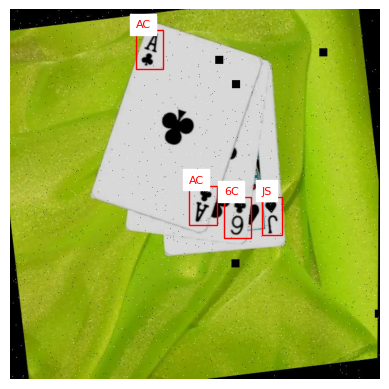

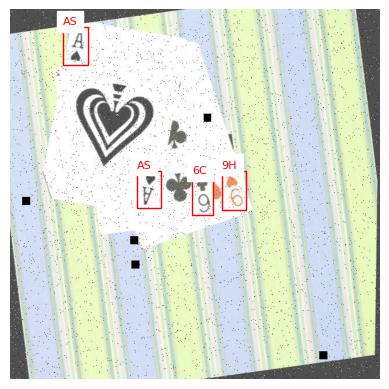

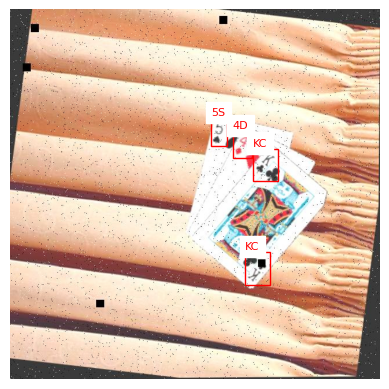

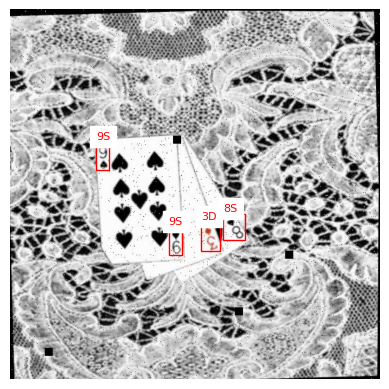

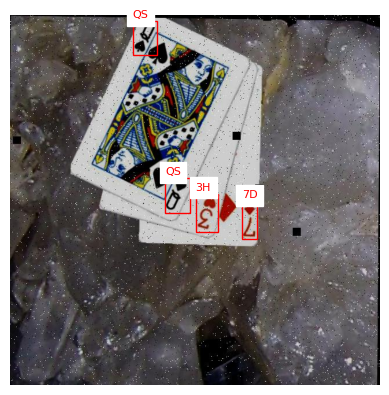

In [8]:
# Visualize some images
def visualize_image_with_annotations(image_id):
    image_info = df[df['ImageID'] == image_id].iloc[0]
    annotations = image_info['BoundingBoxes']
    image_path = os.path.join(train_imgs_path, image_info['FileName'])

    # Show image
    image = plt.imread(image_path)
    plt.imshow(image)
    
    # Draw bounding box and label on image
    for ann in annotations:
        bbox = ann
        category = image_info['Categories'][annotations.index(ann)]

        x, y, width, height = bbox
        rect = plt.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')
        plt.gca().add_patch(rect)
        plt.text(x, y - 5, category, fontsize=8, color='r', backgroundcolor='w')

    plt.axis('off')
    plt.show()

# Show some random images
for image_id in range(5):
    idx = random.randint(0, len(df)-1) 
    visualize_image_with_annotations(idx)

In [9]:
# Calculate mean and standard deviation of each color channel in the train set
# Used to serve for data normalization when training
train_set = PlayingCardDataset(train=True, transform=ToTensor())

train_loader = DataLoader(train_set, batch_size=1)
mean = 0.0
std = 0.0
num_samples = train_set.__len__()

progress_bar = tqdm(train_loader, colour="green")
for images, _ in progress_bar:
    images = images.view(images.size(0), images.size(1), -1)
    mean += torch.mean(images, dim=2).sum(0)
    std += torch.std(images, dim=2).sum(0)

mean /= num_samples
std /= num_samples

print("Mean:", mean)
print("Std:", std)

100%|██████████| 21203/21203 [14:58<00:00, 23.59it/s]

Mean: tensor([0.5531, 0.5128, 0.4813])
Std: tensor([0.2496, 0.2552, 0.2591])
